# SENEX (2013)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import readsav
import warnings
warnings.filterwarnings('ignore')
%pylab inline

matplotlib.rcParams.update({'font.size': 16})

Populating the interactive namespace from numpy and matplotlib


## Retrieve AM3 along flight tracks (courtesy J. Mao)

In [20]:
modf = readsav('idl/mod_all_RunI3d_4_donnerfull.sav')

a3vars = ['TIME', 'PRES', 'O3', 'PAN', 'MPAN', 'R4N2', 
          'NO', 'NO2', 'NO3', 'HNO3', 'CO', 'SO2']

mod = pd.DataFrame({ a3vars[0]: modf.am3[a3vars[0]][0].byteswap().newbyteorder(), 
                      a3vars[1]: modf.am3[a3vars[1]][0].byteswap().newbyteorder(), 
                      a3vars[2]: modf.am3[a3vars[2]][0].byteswap().newbyteorder(), 
                      a3vars[3]: modf.am3[a3vars[3]][0].byteswap().newbyteorder(), 
                      a3vars[4]: modf.am3[a3vars[4]][0].byteswap().newbyteorder(), 
                      a3vars[5]: modf.am3[a3vars[5]][0].byteswap().newbyteorder(), 
                      a3vars[6]: modf.am3[a3vars[6]][0].byteswap().newbyteorder(), 
                      a3vars[7]: modf.am3[a3vars[7]][0].byteswap().newbyteorder(), 
                      a3vars[8]: modf.am3[a3vars[8]][0].byteswap().newbyteorder(), 
                      a3vars[9]: modf.am3[a3vars[9]][0].byteswap().newbyteorder(), 
                      a3vars[10]: modf.am3[a3vars[10]][0].byteswap().newbyteorder(), 
                      a3vars[11]: modf.am3[a3vars[11]][0].byteswap().newbyteorder() })

mod['NOx'] = mod['NO'] + mod['NO2']
mod['NOy'] = mod['PAN'] + mod['MPAN'] + mod['R4N2'] + mod['NO'] + \
              mod['NO2'] + mod['NO2'] + mod['NO3'] + mod['HNO3']

## Retrieve aircraft observations

In [21]:
obsf = readsav('idl/mrg60s_P3.sav')

p3vars = ['UTC_MID', 'DATE', 'AMBTEMP', 'DEWPTTEMP', 'H2OMR', 'RELHUMIDITY',
          'STATICPRS', 'CO_PPBV', 'HNO3_PPBV', 'NH3_PPBV', 'NO_PPBV', 
          'NO2_PPBV', 'NOY_PPBV', 'O3_PPBV', 'PAN_PPBV', 'SO2_PPBV']

obs = pd.DataFrame({ p3vars[0]: obsf.p3[p3vars[0]][0].byteswap().newbyteorder(), 
                    p3vars[1]: obsf.p3[p3vars[1]][0].byteswap().newbyteorder(), 
                    p3vars[2]: obsf.p3[p3vars[2]][0].byteswap().newbyteorder(), 
                    p3vars[3]: obsf.p3[p3vars[3]][0].byteswap().newbyteorder(), 
                    p3vars[4]: obsf.p3[p3vars[4]][0].byteswap().newbyteorder(), 
                    p3vars[5]: obsf.p3[p3vars[5]][0].byteswap().newbyteorder(), 
                    p3vars[6]: obsf.p3[p3vars[6]][0].byteswap().newbyteorder(), 
                    p3vars[7]: obsf.p3[p3vars[7]][0].byteswap().newbyteorder(), 
                    p3vars[8]: obsf.p3[p3vars[8]][0].byteswap().newbyteorder(), 
                    p3vars[9]: obsf.p3[p3vars[9]][0].byteswap().newbyteorder(), 
                    p3vars[10]: obsf.p3[p3vars[10]][0].byteswap().newbyteorder(), 
                    p3vars[11]: obsf.p3[p3vars[11]][0].byteswap().newbyteorder(), 
                    p3vars[12]: obsf.p3[p3vars[12]][0].byteswap().newbyteorder(), 
                    p3vars[13]: obsf.p3[p3vars[13]][0].byteswap().newbyteorder(), 
                    p3vars[14]: obsf.p3[p3vars[14]][0].byteswap().newbyteorder(), 
                    p3vars[15]: obsf.p3[p3vars[15]][0].byteswap().newbyteorder() })

obs['NOx'] = np.ma.masked_invalid(obs['NO_PPBV']) + np.ma.masked_invalid(obs['NO2_PPBV'])

In [22]:
polvars = {'CO': 'CO_PPBV', 'HNO3': 'HNO3_PPBV', 'NOx': 'NOx', 
           'NOy': 'NOY_PPBV', 'O3': 'O3_PPBV', 
           'PAN': 'PAN_PPBV', 'SO2': 'SO2_PPBV'}

In [23]:
def vertprof(obs, mod, fac, title):
    obs_s = obs.sort_values('STATICPRS', ascending=False)
    mod_s = mod.sort_values('PRES', ascending=False)
    oprrs = obs_s['STATICPRS'].values.reshape(fac, len(obs_s)/fac)
    mprrs = mod_s['PRES'].values.reshape(fac, len(mod_s)/fac)
    oprrs = np.ma.masked_invalid(oprrs)
    mprrs = np.ma.masked_invalid(mprrs)
    mnop = np.mean(oprrs, axis=1)
    mnmp = np.mean(mprrs, axis=1)
    
    fig = plt.figure(figsize=[12,12])
    for idx, cp in enumerate(polvars):
        fig.add_subplot(2, 4, idx+1)
        
        # Mask observations where negative in order to take interval mean
        odat = obs_s[polvars[cp]].values.reshape(fac, len(obs_s)/fac)
        odat = np.ma.masked_invalid(odat)
        oavg = np.mean(odat/1e9, axis=1)
        osdv = np.std(odat/1e9, axis=1)
            
        # Model interval mean
        mavg = np.mean(mod_s[cp].values.reshape(fac, len(mod_s)/fac), axis=1)
        #msdv = np.std(dsc_mon_s[vrs[cp][1]][4:].values.reshape(8, tlen/8), axis=1)
        
        # Plotting
        plt.errorbar(oavg, mnop, color='b', xerr=osdv, marker= '*', label='P3')
        plt.plot(mavg, mnmp, color='r', marker= '.', label='AM3')
        
        # Formatting
        plt.gca().invert_yaxis()
        plt.ylim([1000, 500])
        
        if cp == 'HNO3':
            plt.title(r'$HNO_3$')
        elif cp == 'O3':
            plt.title(r'$O_3$')
        elif cp == 'SO2':
            plt.title(r'$SO_2$')
        else:
            plt.title(cp)
        
        if idx==0 or idx==4:
            plt.ylabel('Pressure (hPa)')
        if idx > 3:
            plt.xlabel('\n Mixing Ratio')
        if idx == 6:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.suptitle('SENEX: ' + title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig;

Dates for SENEX:

In [24]:
np.transpose(np.sort(list(set(obs['DATE']))))

array([20130603, 20130610, 20130611, 20130612, 20130616, 20130618,
       20130619, 20130622, 20130623, 20130625, 20130626, 20130629,
       20130702, 20130703, 20130705, 20130706, 20130708, 20130710])

In [25]:
obs_cam = obs
mod_cam = mod
obs_jun = obs[obs['DATE']<20130701]
mod_jun = mod[obs['DATE']<20130701]
obs_jul = obs[obs['DATE']>20130630]
mod_jul = mod[obs['DATE']>20130630]

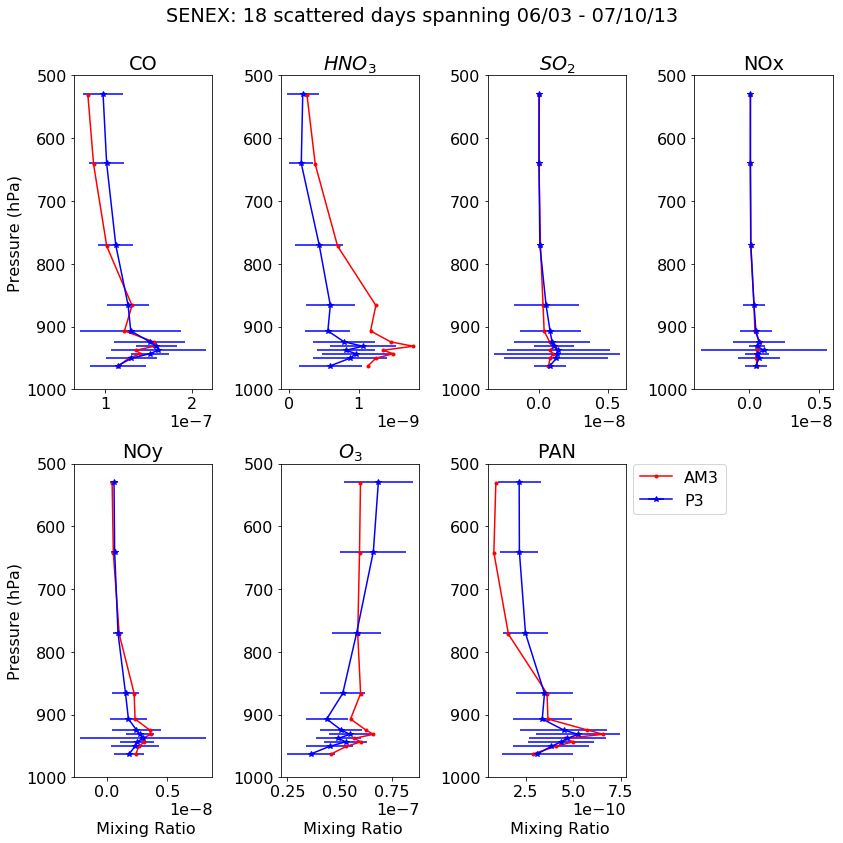

In [26]:
vpc = vertprof(obs_cam, mod_cam, 11, '18 scattered days spanning 06/03 - 07/10/13')
vpc.show()
plt.savefig('python/senex_prof.jpg')

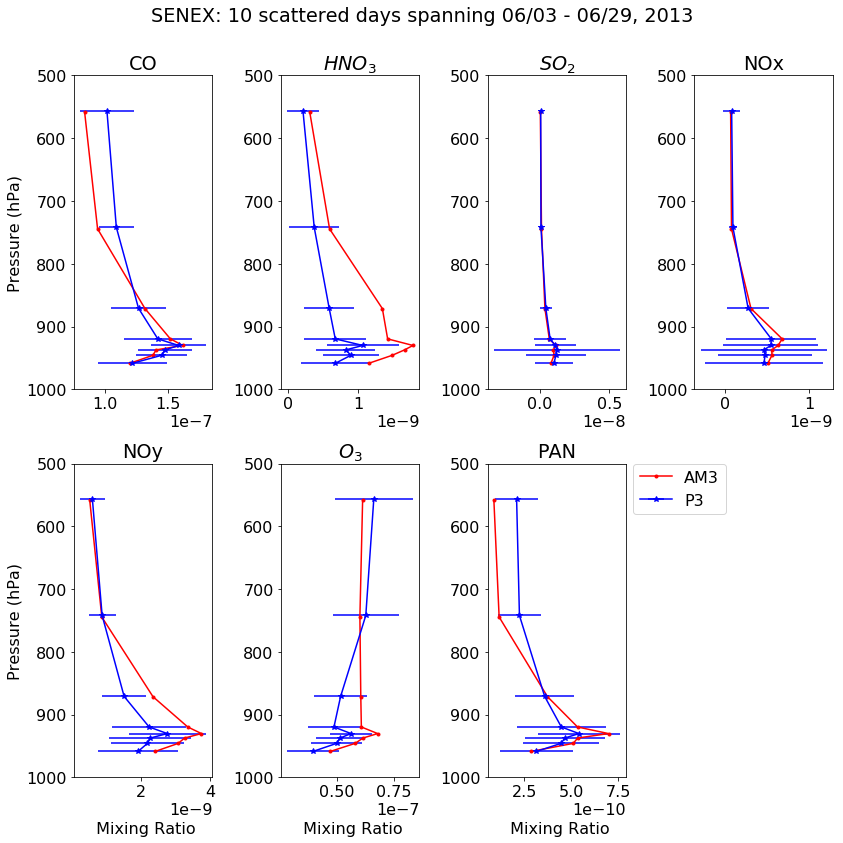

In [27]:
vpn = vertprof(obs_jun[1:], mod_jun[1:], 8, '10 scattered days spanning 06/03 - 06/29, 2013')
plt.savefig('python/senex_jun.jpg')

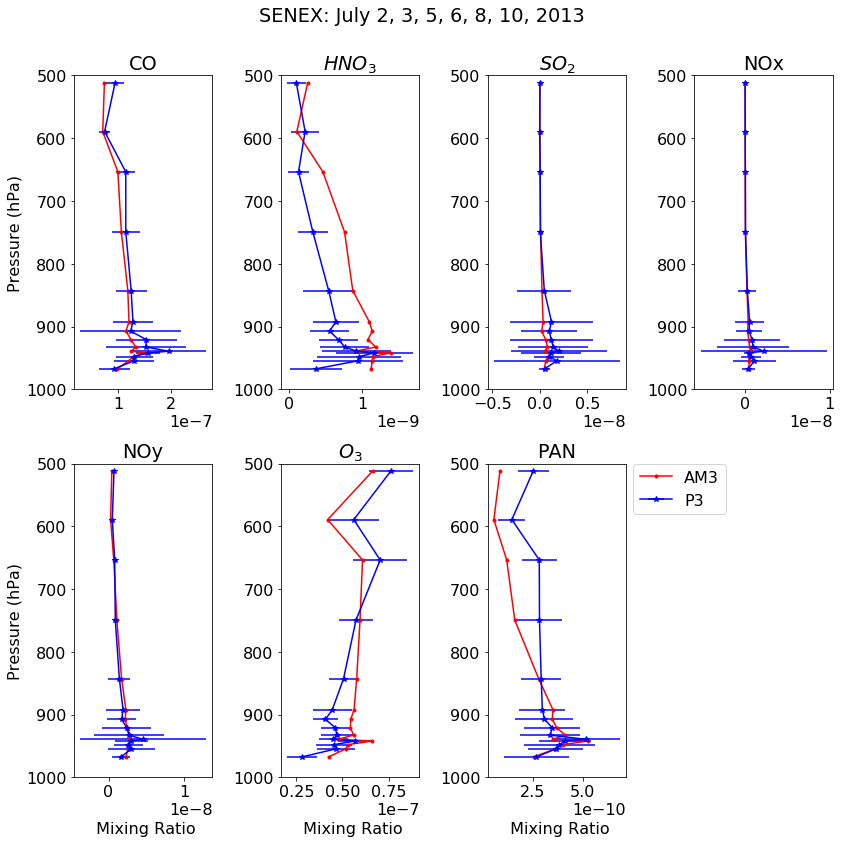

In [28]:
vpl = vertprof(obs_jul[2:], mod_jul[2:], 14, 'July 2, 3, 5, 6, 8, 10, 2013')
plt.savefig('python/senex_jul.jpg')

## Subset aircraft data by meteorological observation

##### Define function for plotting vertical profiles

In [30]:
def metsub(dat, varn, cmap, desc):
    fig = plt.figure(figsize=[12,12])
    for idx, var in enumerate(polvars):
        fig.add_subplot(2, 4, idx+1)
        met = dat[varn]
        pdat = np.ma.masked_invalid(dat[polvars[var]])/1e9
        
        # Plotting
        obj = plt.scatter(pdat, dat['STATICPRS'], c=met, cmap=cmap, marker = '.')
        
        # Formatting
        plt.gca().invert_yaxis()
        plt.ylim([1000, 400])
        rng = pdat.max() - pdat.min()


        if var=='HNO3' or var=='PAN':
            plt.xlim([-0.05 * rng, pdat.max()])
        elif var=='O3':
            plt.xlim([0., 1.5e-7])
        else:
            plt.xlim([-0.05 * rng, pdat.max()/3])
        
        if var=='O3':
            plt.title(r'$O_3$')
        elif var=='HNO3':
            plt.title(r'$HNO_3$')
        elif var=='SO2':
            plt.title(r'$SO_2$')
        elif var=='NH3':
            plt.title(r'$NH_3$')
        else:
            plt.title(var)
            
        if idx==0 or idx==4:
            plt.ylabel('Pressure (hPa)')
        if idx>3:
            plt.xlabel('\n Mixing Ratio')
            
    cbar_ax = fig.add_axes([0.95, 0.15, 0.04, 0.7])
    fig.colorbar(obj, cax=cbar_ax)
    plt.suptitle(desc + '\n SENEX: Scattered dates in June and early July, 2013')
    plt.tight_layout()
    plt.subplots_adjust(top=0.87, right=0.9)
    return fig;

Add $NH_3$ to _polvars_

In [31]:
polvars['NH3'] = 'NH3_PPBV'

### Temperature

##### Ambient Temperature

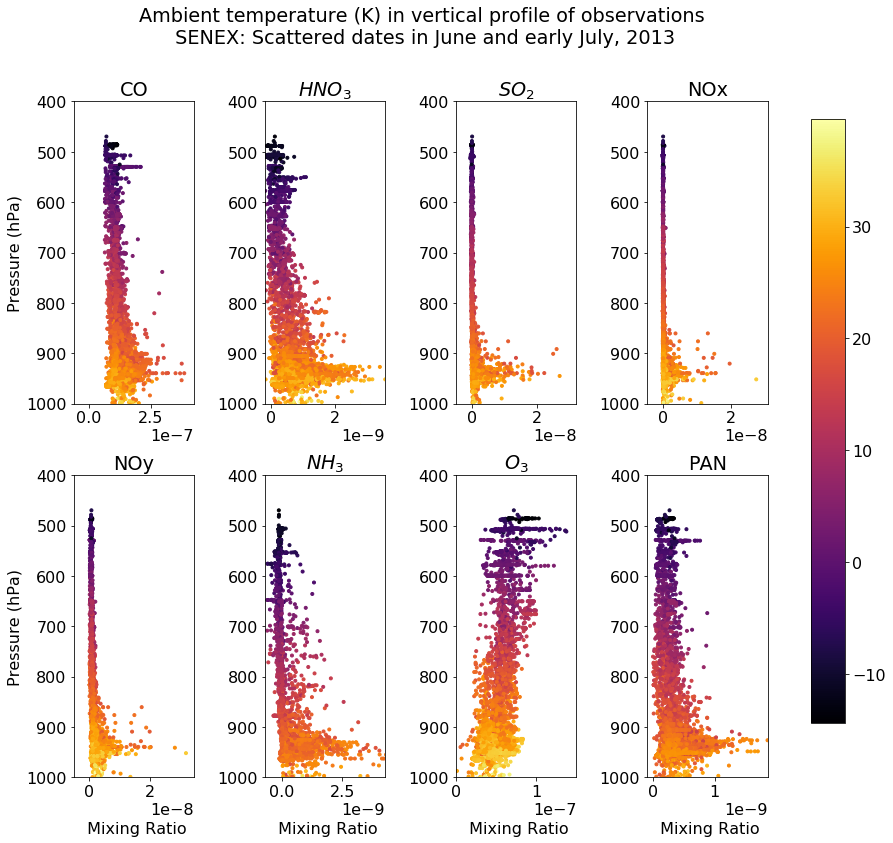

In [34]:
at = metsub(obs, 'AMBTEMP', 'inferno', 'Ambient temperature (K) in vertical profile of observations')
plt.savefig('python/senex_at.jpg')

##### Dew Point Temperature

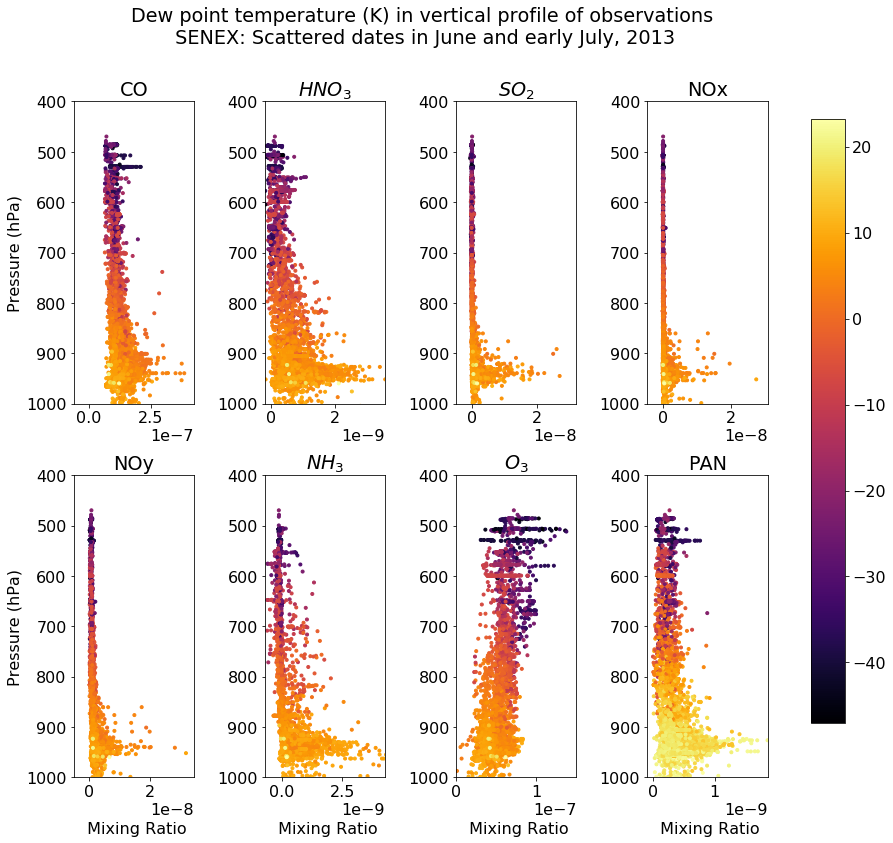

In [35]:
dp = metsub(obs, 'DEWPTTEMP', 'inferno', 'Dew point temperature (K) in vertical profile of observations')
plt.savefig('python/senex_dp.jpg')

### Moisture Indicators

##### Relative Humidity

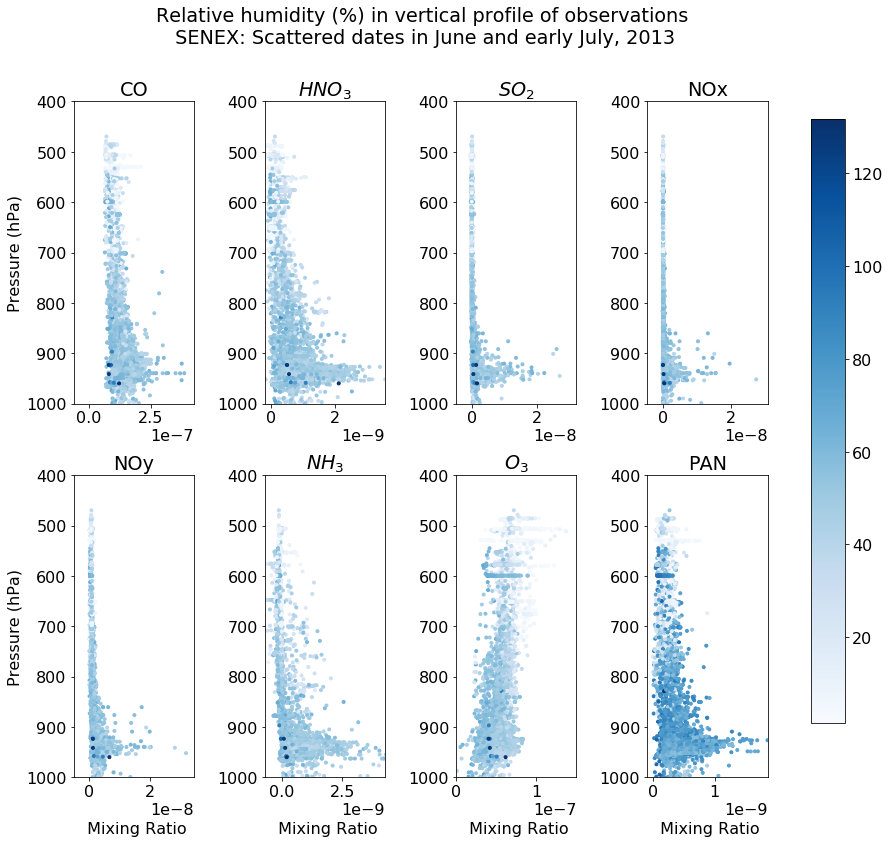

In [36]:
rh = metsub(obs, 'RELHUMIDITY', 'Blues', 'Relative humidity (%) in vertical profile of observations')
plt.savefig('python/senex_rh.jpg')

##### $H_2O$ Mixing Ratio

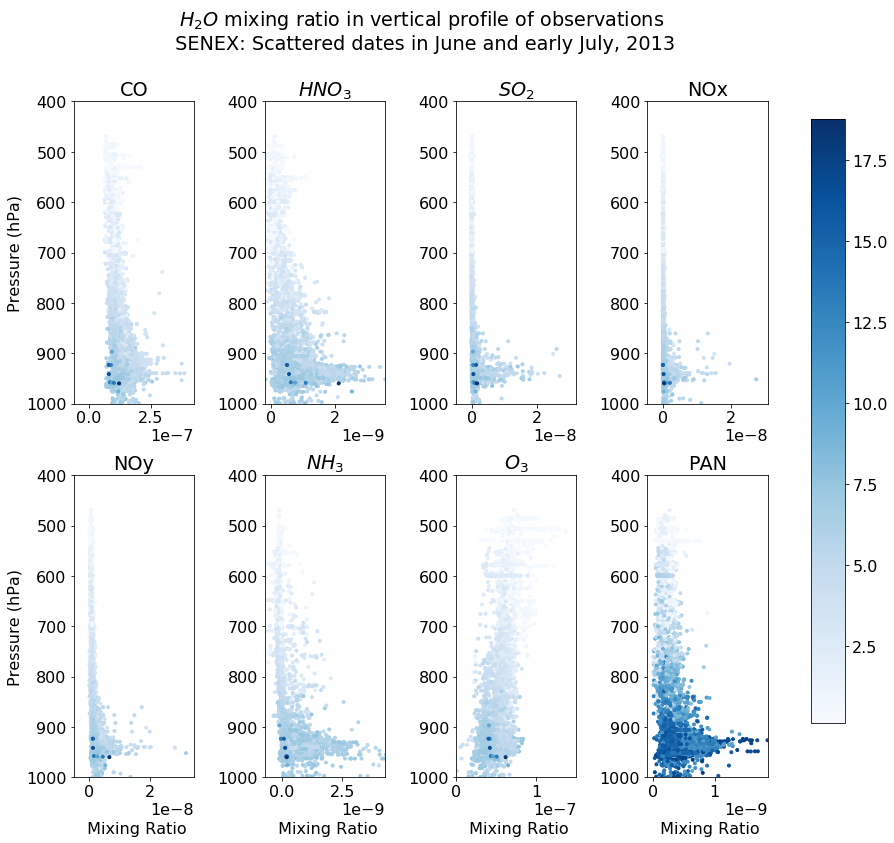

In [37]:
mr = metsub(obs, 'H2OMR', 'Blues', r'$H_2O$' + ' mixing ratio in vertical profile of observations')
plt.savefig('python/senex_mr.jpg')